<a href="https://colab.research.google.com/github/rgnemasters/nfl-combine-draft-2022/blob/main/Combine_ML_Modelling_Steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive, Import Libraries, Load Files

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced

In [63]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_table.xlsx')
qb_df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_qb_table.xlsx')
wr_df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_wr_table.xlsx')
rb_df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_rb_table.xlsx')
db_df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_db_table.xlsx')
others_df = pd.read_excel('/content/drive/MyDrive/Datasets/combine_others_table.xlsx')

In [4]:
print(df.info())
display(df.head())
round(df.isna().sum() / len(df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327 entries, 0 to 7326
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7327 non-null   int64  
 1   Player       7327 non-null   object 
 2   Pos          7327 non-null   object 
 3   School       7327 non-null   object 
 4   Ht           7327 non-null   int64  
 5   Wt           7327 non-null   int64  
 6   40yd         6956 non-null   float64
 7   Vertical     5696 non-null   float64
 8   Bench        5009 non-null   float64
 9   Broad Jump   5632 non-null   float64
 10  3Cone        4692 non-null   float64
 11  Shuttle      4787 non-null   float64
 12  Year         7327 non-null   int64  
 13  team         7327 non-null   object 
 14  round        7327 non-null   int64  
 15  pick number  7327 non-null   int64  
dtypes: float64(6), int64(6), object(4)
memory usage: 916.0+ KB
None


,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,team,round,pick number
0,0,John Abraham,OLB,South Carolina,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,New York Jets,1,13
1,1,Shaun Alexander,RB,Alabama,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,Seattle Seahawks,1,19
2,2,Darnell Alford,OT,Boston Col.,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,Kansas City Chiefs,6,188
3,3,Kyle Allamon,TE,Texas Tech,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,Undrafted,8,260
4,4,Rashard Anderson,CB,Jackson State,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,Carolina Panthers,1,23


Unnamed: 0     0.00
Player         0.00
Pos            0.00
School         0.00
Ht             0.00
Wt             0.00
40yd           0.05
Vertical       0.22
Bench          0.32
Broad Jump     0.23
3Cone          0.36
Shuttle        0.35
Year           0.00
team           0.00
round          0.00
pick number    0.00
dtype: float64

In [5]:
print(qb_df.info())
display(qb_df.head())
round(qb_df.isna().sum() / len(qb_df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        401 non-null    int64  
 1   Player            401 non-null    object 
 2   Pos               401 non-null    object 
 3   School            401 non-null    object 
 4   Ht                401 non-null    int64  
 5   Wt                401 non-null    int64  
 6   40yd              384 non-null    float64
 7   Vertical          329 non-null    float64
 8   Broad Jump        331 non-null    float64
 9   3Cone             310 non-null    float64
 10  Shuttle           314 non-null    float64
 11  Year              401 non-null    int64  
 12  team              401 non-null    object 
 13  round             401 non-null    int64  
 14  pick number       401 non-null    int64  
 15  Y/A               339 non-null    float64
 16  AY/A              339 non-null    float64
 1

,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,Year,team,round,pick number,Y/A,AY/A,Rate,Total TDs/season,Rush Avg.
0,0,Tom Brady,QB,Michigan,76,211,5.28,24.5,99.0,7.20,4.38,2000,New England Patriots,6,199,7.5,7.7,138.0,17.0,-0.9
1,1,Travis Brown,QB,Northern Arizona,75,218,5.01,29.0,101.0,7.54,4.87,2000,Undrafted,8,260,NaN,NaN,NaN,NaN,NaN
2,2,Marc Bulger,QB,West Virginia,74,208,4.97,NaN,100.0,7.46,4.34,2000,New Orleans Saints,6,168,NaN,NaN,NaN,NaN,NaN
3,3,Bill Burke,QB,Michigan State,76,206,5.03,28.5,107.0,7.46,4.42,2000,Undrafted,8,260,7.1,5.8,124.7,20.0,-4.1
4,4,Giovanni Carmazzi,QB,Hofstra,75,224,4.74,36.5,119.0,6.94,4.23,2000,San Francisco 49ers,3,65,NaN,NaN,NaN,NaN,NaN


Unnamed: 0          0.00
Player              0.00
Pos                 0.00
School              0.00
Ht                  0.00
Wt                  0.00
40yd                0.04
Vertical            0.18
Broad Jump          0.17
3Cone               0.23
Shuttle             0.22
Year                0.00
team                0.00
round               0.00
pick number         0.00
Y/A                 0.15
AY/A                0.15
Rate                0.15
Total TDs/season    0.15
Rush Avg.           0.15
dtype: float64

In [6]:
print(rb_df.info())
display(rb_df.head())
round(rb_df.isna().sum() / len(rb_df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    635 non-null    int64  
 1   Player                        635 non-null    object 
 2   Pos                           635 non-null    object 
 3   School                        635 non-null    object 
 4   Ht                            635 non-null    int64  
 5   Wt                            635 non-null    int64  
 6   40yd                          619 non-null    float64
 7   Vertical                      528 non-null    float64
 8   Bench                         496 non-null    float64
 9   Broad Jump                    520 non-null    float64
 10  3Cone                         373 non-null    float64
 11  Shuttle                       379 non-null    float64
 12  Year                          635 non-null    int64  
 13  team 

,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,team,round,pick number,Avg/Rush,Avg/Rec,Total TDs/season,Total Scrimmage Plays/season
0,0,Shaun Alexander,RB,Alabama,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,Seattle Seahawks,1,19,4.6,12.9,23.0,327.0
1,1,Keith Brown,RB,UCLA,71,216,4.66,30.0,NaN,117.0,6.64,4.08,2000,Undrafted,8,260,4.3,2.4,5.0,105.0
2,2,Demario Brown,RB,Utah State,72,217,4.72,31.0,NaN,107.0,7.17,4.39,2000,Undrafted,8,260,5.5,10.8,15.0,305.0
3,3,Trung Canidate,RB,Arizona,71,193,4.41,NaN,18.0,NaN,NaN,NaN,2000,St. Louis Rams,1,31,6.3,8.4,12.0,283.0
4,4,Doug Chapman,RB,Marshall,70,215,4.56,38.5,16.0,128.0,6.84,4.20,2000,Minnesota Vikings,3,88,4.2,13.4,13.0,188.0


Unnamed: 0                      0.00
Player                          0.00
Pos                             0.00
School                          0.00
Ht                              0.00
Wt                              0.00
40yd                            0.03
Vertical                        0.17
Bench                           0.22
Broad Jump                      0.18
3Cone                           0.41
Shuttle                         0.40
Year                            0.00
team                            0.00
round                           0.00
pick number                     0.00
Avg/Rush                        0.14
Avg/Rec                         0.14
Total TDs/season                0.14
Total Scrimmage Plays/season    0.14
dtype: float64

In [64]:
print(db_df.info())
display(db_df.head())
round(db_df.isna().sum() / len(db_df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1259 non-null   int64  
 1   Player       1259 non-null   object 
 2   Pos          1259 non-null   object 
 3   School       1259 non-null   object 
 4   Ht           1259 non-null   int64  
 5   Wt           1259 non-null   int64  
 6   40yd         1209 non-null   float64
 7   Vertical     1020 non-null   float64
 8   Bench        990 non-null    float64
 9   Broad Jump   1019 non-null   float64
 10  3Cone        761 non-null    float64
 11  Shuttle      778 non-null    float64
 12  Year         1259 non-null   int64  
 13  team         1259 non-null   object 
 14  round        1259 non-null   int64  
 15  pick number  1259 non-null   int64  
dtypes: float64(6), int64(6), object(4)
memory usage: 157.5+ KB
None


,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,team,round,pick number
0,4,Rashard Anderson,CB,Jackson State,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,Carolina Panthers,1,23
1,9,Reggie Austin,CB,Wake Forest,69,175,4.44,35.0,17.0,119.0,7.03,4.14,2000,Chicago Bears,4,125
2,12,Rashidi Barnes,S,Colorado,72,208,4.62,35.0,10.0,114.0,6.92,4.32,2000,Cleveland Browns,7,225
3,13,David Barrett,CB,Arkansas,70,199,4.44,37.5,16.0,116.0,6.81,4.04,2000,Arizona Cardinals,4,102
4,14,William Bartee,CB,Oklahoma,73,192,4.43,38.5,NaN,124.0,6.70,3.99,2000,Kansas City Chiefs,2,54


Unnamed: 0     0.00
Player         0.00
Pos            0.00
School         0.00
Ht             0.00
Wt             0.00
40yd           0.04
Vertical       0.19
Bench          0.21
Broad Jump     0.19
3Cone          0.40
Shuttle        0.38
Year           0.00
team           0.00
round          0.00
pick number    0.00
dtype: float64

In [7]:
print(wr_df.info())
display(wr_df.head())
round(wr_df.isna().sum() / len(wr_df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1018 non-null   int64  
 1   Player                        1018 non-null   object 
 2   Pos                           1018 non-null   object 
 3   School                        1018 non-null   object 
 4   Ht                            1018 non-null   int64  
 5   Wt                            1018 non-null   int64  
 6   40yd                          981 non-null    float64
 7   Vertical                      835 non-null    float64
 8   Broad Jump                    812 non-null    float64
 9   3Cone                         659 non-null    float64
 10  Shuttle                       678 non-null    float64
 11  Year                          1018 non-null   int64  
 12  team                          1018 non-null   object 
 13  rou

,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,Year,team,round,pick number,Avg/Rec,Avg/Rush,Total TDs/season,Total Scrimmage Plays/season
0,0,Plaxico Burress,WR,Michigan State,77,231,4.59,33.0,115.0,NaN,NaN,2000,Pittsburgh Steelers,1,8,17.3,17.3,12.0,66.0
1,1,Kwame Cavil,WR,Texas,74,208,4.54,39.5,118.0,NaN,NaN,2000,Undrafted,8,260,11.9,11.7,6.0,101.0
2,2,Chris Cole,WR,Texas A&M,72,191,4.37,37.5,125.0,6.76,4.09,2000,Denver Broncos,3,70,16.5,16.5,0.0,22.0
3,3,Chris Coleman,WR,North Carolina State,72,211,4.61,32.5,110.0,6.79,4.10,2000,Undrafted,8,260,11.9,11.6,1.0,42.0
4,4,Laveranues Coles,WR,Florida State,71,192,4.41,34.0,115.0,6.89,4.39,2000,New York Jets,3,78,NaN,NaN,NaN,NaN


Unnamed: 0                      0.00
Player                          0.00
Pos                             0.00
School                          0.00
Ht                              0.00
Wt                              0.00
40yd                            0.04
Vertical                        0.18
Broad Jump                      0.20
3Cone                           0.35
Shuttle                         0.33
Year                            0.00
team                            0.00
round                           0.00
pick number                     0.00
Avg/Rec                         0.16
Avg/Rush                        0.16
Total TDs/season                0.16
Total Scrimmage Plays/season    0.16
dtype: float64

In [8]:
print(others_df.info())
display(others_df.head())
round(others_df.isna().sum() / len(others_df), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3748 non-null   int64  
 1   Player       3748 non-null   object 
 2   Pos          3748 non-null   object 
 3   School       3748 non-null   object 
 4   Ht           3748 non-null   int64  
 5   Wt           3748 non-null   int64  
 6   40yd         3571 non-null   float64
 7   Vertical     2956 non-null   float64
 8   Bench        2962 non-null   float64
 9   Broad Jump   2922 non-null   float64
 10  3Cone        2575 non-null   float64
 11  Shuttle      2623 non-null   float64
 12  Year         3748 non-null   int64  
 13  team         3748 non-null   object 
 14  round        3748 non-null   int64  
 15  pick number  3748 non-null   int64  
dtypes: float64(6), int64(6), object(4)
memory usage: 468.6+ KB
None


,Unnamed: 0,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,team,round,pick number
0,0,John Abraham,OLB,South Carolina,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,New York Jets,1,13
1,2,Darnell Alford,OT,Boston Col.,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,Kansas City Chiefs,6,188
2,3,Kyle Allamon,TE,Texas Tech,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,Undrafted,8,260
3,6,LaVar Arrington,OLB,Penn State,75,250,4.53,NaN,NaN,NaN,NaN,NaN,2000,Washington Redskins,1,2
4,7,Corey Atkins,OLB,South Carolina,72,237,4.72,31.0,21.0,112.0,7.96,4.39,2000,Undrafted,8,260


Unnamed: 0     0.00
Player         0.00
Pos            0.00
School         0.00
Ht             0.00
Wt             0.00
40yd           0.05
Vertical       0.21
Bench          0.21
Broad Jump     0.22
3Cone          0.31
Shuttle        0.30
Year           0.00
team           0.00
round          0.00
pick number    0.00
dtype: float64

# Pre-processing 

##Final data cleaning steps

In [66]:
#establish dictionary for iterating through
dfs = {'Source Table': df,
       'QB Table': qb_df,
       'WR Table': wr_df,
       'RB Table': rb_df,
       'Others Table': others_df,
       'DB Table': db_df}

In [67]:
for title, data in dfs.items():
  data.drop(columns = ['Unnamed: 0', 'Year'], inplace=True)
  print(title, data.columns)

Source Table Index(['Player', 'Pos', 'School', 'Ht', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'team', 'round', 'pick number'],
      dtype='object')
QB Table Index(['Player', 'Pos', 'School', 'Ht', 'Wt', '40yd', 'Vertical', 'Broad Jump',
       '3Cone', 'Shuttle', 'team', 'round', 'pick number', 'Y/A', 'AY/A',
       'Rate', 'Total TDs/season', 'Rush Avg.'],
      dtype='object')
WR Table Index(['Player', 'Pos', 'School', 'Ht', 'Wt', '40yd', 'Vertical', 'Broad Jump',
       '3Cone', 'Shuttle', 'team', 'round', 'pick number', 'Avg/Rec',
       'Avg/Rush', 'Total TDs/season', 'Total Scrimmage Plays/season'],
      dtype='object')
RB Table Index(['Player', 'Pos', 'School', 'Ht', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'team', 'round', 'pick number',
       'Avg/Rush', 'Avg/Rec', 'Total TDs/season',
       'Total Scrimmage Plays/season'],
      dtype='object')
Others Table Index(['Player', 'Pos', 'School', 'Ht', 'Wt', '

## Data Validation Split

In [68]:
#Review balance of target column 'round'
for title, data in dfs.items():
  print(title, '\n\n')
  print(round(data['round'].value_counts(normalize=True), 2))
  print('\n\n')

Source Table 


8    0.36
3    0.10
4    0.10
1    0.09
2    0.09
5    0.09
6    0.08
7    0.08
Name: round, dtype: float64



QB Table 


8    0.40
1    0.16
6    0.09
5    0.07
4    0.07
7    0.07
3    0.07
2    0.06
Name: round, dtype: float64



WR Table 


8    0.40
2    0.10
3    0.10
4    0.09
6    0.09
1    0.08
5    0.08
7    0.07
Name: round, dtype: float64



RB Table 


8    0.42
4    0.11
3    0.09
2    0.08
1    0.08
6    0.08
7    0.08
5    0.06
Name: round, dtype: float64



Others Table 


8    0.33
3    0.11
4    0.10
1    0.10
5    0.10
2    0.09
7    0.08
6    0.08
Name: round, dtype: float64



DB Table 


8    0.30
2    0.12
4    0.12
3    0.11
5    0.11
1    0.10
6    0.08
7    0.07
Name: round, dtype: float64





After review, I may consider balancing the target, since 30-40% of the values are '8' (meaning 'undrafted').

In [69]:
#Establish 'round' as target, split data for each DF
from sklearn.model_selection import train_test_split
df_y = df['round']
df_X = df.drop(columns='round')
df_Xtrain, df_Xtest, df_ytrain, df_ytest = train_test_split(df_X, df_y, random_state=42)

In [70]:
qb_y = qb_df['round']
qb_X = qb_df.drop(columns='round')
qb_Xtrain, qb_Xtest, qb_ytrain, qb_ytest = train_test_split(qb_X, qb_y, random_state=42)

In [71]:
wr_y = wr_df['round']
wr_X = wr_df.drop(columns='round')
wr_Xtrain, wr_Xtest, wr_ytrain, wr_ytest = train_test_split(wr_X, wr_y, random_state=42)

In [72]:
rb_y = rb_df['round']
rb_X = rb_df.drop(columns='round')
rb_Xtrain, rb_Xtest, rb_ytrain, rb_ytest = train_test_split(rb_X, rb_y, random_state=42)

In [73]:
db_y = db_df['round']
db_X = db_df.drop(columns='round')
db_Xtrain, db_Xtest, db_ytrain, db_ytest = train_test_split(db_X, db_y, random_state=42)

In [74]:
others_y = others_df['round']
others_X = others_df.drop(columns='round')
others_Xtrain, others_Xtest, others_ytrain, others_ytest = train_test_split(others_X, others_y, random_state=42)

##Instantiate Selectors, Imputers, and Transformers

In [75]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer

In [76]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

mean_imputer = SimpleImputer()

## Build Pipelines

In [77]:
#Pipelines should impute mean values to nulls, and OneHotEncode object categories
num_pipe = make_pipeline(mean_imputer, scaler)

num_tuple = (num_pipe, num_selector)
cat_tuple = (ohe, cat_selector)

transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

##Tuning Hyperparameters and Testing Models

In [78]:
#Instantiate models
rf = RandomForestClassifier(class_weight='balanced')
logreg = LogisticRegression(class_weight='balanced')
lgbm = LGBMClassifier(class_weight='balanced')
smote = SMOTE()

###Tuning Hyperparameters

In [79]:
#Instantiate model pipelines
rf_pipe = make_pipeline(transformer, rf)
lgbm_pipe = make_pipeline(transformer, lgbm)
logreg_pipe = make_pipeline(transformer, logreg)
smote_pipe = make_pipeline(transformer, smote);

In [101]:
#Instantiate parameter grids for GridCV tuning
rf_params = {'randomforestclassifier__max_depth': range(12, 38, 2),
             'randomforestclassifier__min_samples_leaf': [1,2,3]}
logreg_params = {'logisticregression__C': [.01, .1, 1.0, 10, 100, 1000],
                 'logisticregression__penalty': ['l1', 'l2'],
                 'logisticregression__solver': ['liblinear']}
lgbm_params = {'lgbmclassifier__max_depth': range(12, 38, 2),
             'lgbmclassifier__min_samples_leaf': [1,2,3]}
smote_params = {'smote__k_neighbors': range(5, 11),
                'smote__sampling_strategy': ['auto', 'minority']}
#Instantiate dictionary for looping
model_params = {rf_pipe: rf_params,
                logreg_pipe: logreg_params,
                lgbm_pipe: lgbm_params}
results = []

In [118]:
def grid_tuner(Xtrain=df_Xtrain, ytrain=df_ytrain, Xtest=df_Xtest, 
               ytest = df_ytest):
 
  for model, params in model_params.items():
    grid = GridSearchCV(model, params, verbose=1, cv=3, n_jobs=-1, scoring="recall_macro")
    grid.fit(Xtrain, ytrain)
    print(grid.best_params_)
    
    ypred_test = grid.predict(Xtest)
    class_report = classification_report(ytest, ypred_test)
    print(class_report)
    
    results.append('WR Table:\n\n')
    results.append(grid.best_params_)
    results.append(class_report)

In [103]:
#Run metrics for each DF and then view reports
grid_tuner()

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 34, 'randomforestclassifier__min_samples_leaf': 1}
              precision    recall  f1-score   support

           1       0.90      1.00      0.95       161
           2       0.77      0.78      0.78       148
           3       0.41      0.53      0.46       175
           4       0.31      0.32      0.31       189
           5       0.31      0.27      0.29       179
           6       0.36      0.33      0.34       150
           7       0.58      0.41      0.48       150
           8       1.00      1.00      1.00       680

    accuracy                           0.69      1832
   macro avg       0.58      0.58      0.58      1832
weighted avg       0.69      0.69      0.69      1832

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

In [105]:
grid_tuner(Xtrain=qb_Xtrain, ytrain=qb_ytrain, Xtest=qb_Xtest, 
               ytest = qb_ytest)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 18, 'randomforestclassifier__min_samples_leaf': 2}
              precision    recall  f1-score   support

           1       0.81      0.93      0.87        14
           2       0.20      0.33      0.25         3
           3       0.50      0.50      0.50         8
           4       0.25      0.08      0.12        13
           5       0.33      0.29      0.31         7
           6       0.13      0.33      0.19         6
           7       0.43      0.30      0.35        10
           8       1.00      1.00      1.00        40

    accuracy                           0.65       101
   macro avg       0.46      0.47      0.45       101
weighted avg       0.66      0.65      0.65       101

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'lgbmclassifier__max_depth': 12, 'lgbmclassifier__min_samples_leaf': 1}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         8
           4       1.00      0.69      0.82        13
           5       1.00      1.00      1.00         7
           6       0.60      1.00      0.75         6
           7       1.00      0.60      0.75        10
           8       1.00      1.00      1.00        40

    accuracy                           0.92       101
   macro avg       0.91      0.91      0.89       101
weighted avg       0.95      0.92      0.92       101



In [112]:
grid_tuner(Xtrain=db_Xtrain, ytrain=db_ytrain, Xtest=db_Xtest, 
               ytest = db_ytest)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 32, 'randomforestclassifier__min_samples_leaf': 1}
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        32
           2       0.85      0.89      0.87        38
           3       0.55      0.56      0.55        32
           4       0.45      0.80      0.58        30
           5       0.61      0.25      0.35        44
           6       0.44      0.75      0.56        20
           7       0.83      0.22      0.34        23
           8       0.98      1.00      0.99        96

    accuracy                           0.75       315
   macro avg       0.71      0.68      0.65       315
weighted avg       0.77      0.75      0.73       315

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

In [114]:
grid_tuner(Xtrain=rb_Xtrain, ytrain=rb_ytrain, Xtest=rb_Xtest, 
               ytest = rb_ytest)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 24, 'randomforestclassifier__min_samples_leaf': 2}
              precision    recall  f1-score   support

           1       0.64      0.90      0.75        10
           2       0.57      0.57      0.57        14
           3       0.12      0.09      0.11        11
           4       0.32      0.47      0.38        19
           5       0.17      0.18      0.17        11
           6       0.50      0.19      0.27        16
           7       0.56      0.50      0.53        18
           8       0.98      1.00      0.99        60

    accuracy                           0.64       159
   macro avg       0.48      0.49      0.47       159
weighted avg       0.63      0.64      0.62       159

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

In [116]:
grid_tuner(Xtrain=others_Xtrain, ytrain=others_ytrain, Xtest=others_Xtest, 
               ytest = others_ytest)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 36, 'randomforestclassifier__min_samples_leaf': 1}
              precision    recall  f1-score   support

           1       0.88      0.99      0.93       100
           2       0.73      0.75      0.74        88
           3       0.58      0.68      0.62       112
           4       0.41      0.40      0.41        95
           5       0.43      0.34      0.38       104
           6       0.36      0.28      0.31        65
           7       0.50      0.54      0.52        71
           8       1.00      1.00      1.00       302

    accuracy                           0.72       937
   macro avg       0.61      0.62      0.61       937
weighted avg       0.71      0.72      0.71       937

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

In [119]:
grid_tuner(Xtrain=wr_Xtrain, ytrain=wr_ytrain, Xtest=wr_Xtest, 
               ytest = wr_ytest)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_leaf': 1}
              precision    recall  f1-score   support

           1       0.83      0.83      0.83        23
           2       0.52      0.77      0.62        22
           3       0.54      0.24      0.33        29
           4       0.41      0.41      0.41        22
           5       0.27      0.41      0.33        17
           6       0.58      0.68      0.62        22
           7       0.57      0.27      0.36        15
           8       1.00      1.00      1.00       105

    accuracy                           0.72       255
   macro avg       0.59      0.58      0.56       255
weighted avg       0.73      0.72      0.71       255

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
              precision   

In [142]:
results

['Main Table:\n\n',
 {'randomforestclassifier__max_depth': 34,
  'randomforestclassifier__min_samples_leaf': 1},
 '              precision    recall  f1-score   support\n\n           1       0.90      1.00      0.95       161\n           2       0.77      0.78      0.78       148\n           3       0.41      0.53      0.46       175\n           4       0.31      0.32      0.31       189\n           5       0.31      0.27      0.29       179\n           6       0.36      0.33      0.34       150\n           7       0.58      0.41      0.48       150\n           8       1.00      1.00      1.00       680\n\n    accuracy                           0.69      1832\n   macro avg       0.58      0.58      0.58      1832\nweighted avg       0.69      0.69      0.69      1832\n',
 'Main Table:\n\n',
 {'logisticregression__C': 0.1,
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'liblinear'},
 '              precision    recall  f1-score   support\n\n           1       0.8

In [140]:
main_results = [results[2], results[5], results[8]]
qb_results = [results[11], results[14], results[17]]
db_results = [results[20], results[23], results[26]]
rb_results = [results[29], results[32], results[35]]
others_results = [results[38], results[41], results[44]]
wr_results = [results[47], results[50], results[53]]
results_dict = {'Main Table' : main_results, 
                'QB Table': qb_results, 
                'DB Table': db_results, 
                'RB Table': rb_results,
                'Others': others_results,
                'WRs': wr_results}

In [141]:
for title, report in results_dict.items():
  print(title, '\n\n')
  print(report[0])
  print(report[1])
  print(report[2])
  print('\n\n')

Main Table 


              precision    recall  f1-score   support

           1       0.90      1.00      0.95       161
           2       0.77      0.78      0.78       148
           3       0.41      0.53      0.46       175
           4       0.31      0.32      0.31       189
           5       0.31      0.27      0.29       179
           6       0.36      0.33      0.34       150
           7       0.58      0.41      0.48       150
           8       1.00      1.00      1.00       680

    accuracy                           0.69      1832
   macro avg       0.58      0.58      0.58      1832
weighted avg       0.69      0.69      0.69      1832

              precision    recall  f1-score   support

           1       0.87      1.00      0.93       161
           2       0.77      0.76      0.77       148
           3       0.75      0.67      0.71       175
           4       0.78      0.67      0.72       189
           5       0.74      0.74      0.74       179
          

#Instantiating and Testing Final Model

After reviewing the results from tuning the hyperparameters, it appears that LightGBM tuned and utilized on the the main table (df) actually performs better than all but one position-specific grouping. 

Therefore I will shift my focus to building the model around the main table.

In [152]:
#Set up function to evaluate final model 
def model_eval(actual, preds):
  acc_score = accuracy_score(actual, preds)
  prec_score = precision_score(actual, preds, average='weighted')
  rec_score = recall_score(actual, preds, average='weighted')
  class_report = classification_report(actual, preds)
  print(f'Accuracy:{acc_score}\n\nPrecision:{prec_score}\n\n Recall:{rec_score}\n\n')
  print(class_report)
  fig, ax = plt.subplots(figsize=(10,8))
  ConfusionMatrixDisplay.from_predictions(actual, preds, ax = ax);

In [148]:
#Instantiate tuned model and then run metrics
lgbm = LGBMClassifier(max_depth=22, class_weight='balanced', random_state=42)
lgbm_pipe = make_pipeline(transformer, lgbm)
lgbm_pipe.fit(df_Xtrain, df_ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff831deaa90>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff831d

In [155]:
#Check for over-fitness
test_score = lgbm_pipe.score(df_Xtest, df_ytest)
train_score = lgbm_pipe.score(df_Xtrain, df_ytrain)
print(f'Test set score: {test_score}\n\n')
print(f'\n\nTraining set score: {train_score}')

Test set score: 0.949235807860262




Training set score: 1.0


Accuracy:0.949235807860262

Precision:0.9493099491423715

 Recall:0.949235807860262


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       161
           2       0.97      0.98      0.98       148
           3       0.92      0.95      0.93       175
           4       0.93      0.89      0.91       189
           5       0.89      0.85      0.87       179
           6       0.82      0.83      0.83       150
           7       0.91      0.94      0.92       150
           8       1.00      1.00      1.00       680

    accuracy                           0.95      1832
   macro avg       0.93      0.93      0.93      1832
weighted avg       0.95      0.95      0.95      1832



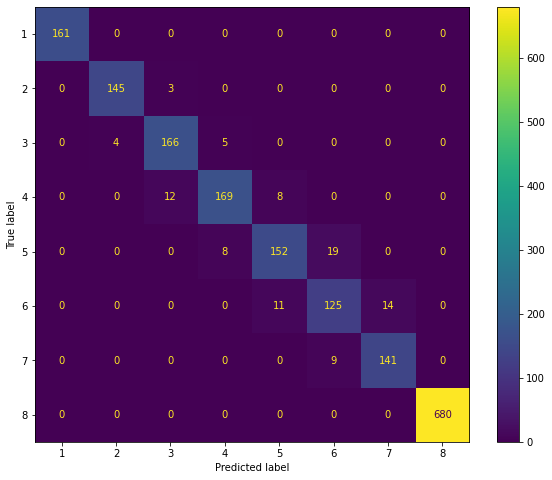

In [153]:
preds = lgbm_pipe.predict(df_Xtest)
model_eval(df_ytest, preds)